# Step 4. Analyses and visualizations 
inputs: 
- `preprocessed_merfish_ad_mouse_rotated.hdf5`
- `clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_...tsv.gz`
- `palette_admouse.json`

outputs:
- cluster visualizations
- gene level analyses

In [13]:
import json
import h5py
import tqdm
import datetime
import time
import pandas as pd
import numpy as np
import collections
from scipy import stats
import datashader as ds
import colorcet

import sys
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')
import utils
import powerplot
from __init__plots import *

# 
import importlib
import _powerplot_vizgen_merfish
importlib.reload(_powerplot_vizgen_merfish)
from _powerplot_vizgen_merfish import *

In [2]:
today = datetime.date.today()
analysis_name = "AD_mouse"
figures = '../figures/{}_{}_{{}}'.format(today, analysis_name)
results = '../data/summary_tables_admouse/{}_{}_{{}}'.format(today, analysis_name)
figures, results

('../figures/2021-07-23_AD_mouse_{}',
 '../data/summary_tables_admouse/2021-07-23_AD_mouse_{}')

In [3]:
!mkdir -p ../figures

# read in processed data
- cell metadata
- cell gene matrix (normalized)
- cell clusters and umap
- palette and other metadata

In [4]:
# palette as json
file = '../data/summary_tables_admouse/palette_admouse.json'
with open(file, 'r') as f:
    palette = json.load(f)
palette

{'Xulab_2_5_region_0': [0.19215686274509805,
  0.5098039215686274,
  0.7411764705882353],
 'Xulab_2_5_region_1': [0.4196078431372549,
  0.6823529411764706,
  0.8392156862745098],
 'Xulab_2_6_region_0': [0.9019607843137255,
  0.3333333333333333,
  0.050980392156862744],
 'Xulab_2_6_region_1': [0.9921568627450981,
  0.5529411764705883,
  0.23529411764705882],
 'Vizgen_region_0': [0.19215686274509805,
  0.6392156862745098,
  0.32941176470588235]}

In [5]:
!ls ../data/summary_tables_admouse/*.tsv.gz

../data/summary_tables_admouse/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.tsv.gz


In [6]:
f = '../data/summary_tables_admouse/clustering_embedding_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.tsv.gz'
clsts = pd.read_csv(f, sep='\t').set_index('cell')
clsts['cluster_cat'] = pd.Categorical(clsts['cluster']) #.astype
print(clsts.shape)
clsts.head()

(450001, 5)


cluster    umap_1    umap_2  \
cell                                                                  
1180572846630481441529138875642910508        C9  1.680950  3.928079   
123728997372594040247704579971571050130      C2  0.278196  2.377322   
141838298513381706222849139789989533595      C9  1.710492  4.529142   
159299836930912089601219931918867429346      C4  2.024679  5.750733   
178901354552570069198396499727421283408      C9  1.874690  5.392705   

                                                     sample cluster_cat  
cell                                                                     
1180572846630481441529138875642910508    Xulab_2_5_region_0          C9  
123728997372594040247704579971571050130  Xulab_2_5_region_0          C2  
141838298513381706222849139789989533595  Xulab_2_5_region_0          C9  
159299836930912089601219931918867429346  Xulab_2_5_region_0          C4  
178901354552570069198396499727421283408  Xulab_2_5_region_0          C9

In [7]:
input = '../data/summary_tables_admouse/processed_merfish_ad_mouse_rotated.hdf5'
samples = [
    'Xulab_2_5_region_0',
    'Xulab_2_5_region_1',
    'Xulab_2_6_region_0',
    'Xulab_2_6_region_1',
]

samples_annot = {
    'Xulab_2_5_region_0': 'WT 2-5',
    'Xulab_2_5_region_1': '5xFAD 2-5',
    'Xulab_2_6_region_0': 'WT 2-6',
    'Xulab_2_6_region_1': '5xFAD 2-6',
}


gmat = []
meta = []

for sample in samples:
    _gmat = pd.read_hdf(input, 'mat_'+sample)
    gmat.append(_gmat)
    _meta = pd.read_hdf(input, 'meta_'+sample)
    _meta['sample'] = sample 
    meta.append(_meta)

gmat = pd.concat(gmat)
meta = pd.concat(meta)


In [8]:
# informations
thedata = clsts.drop('sample', axis=1).join(meta) #.join(clsts)
genes = gmat.columns
thedatagmat = thedata.join(gmat)
print(len(genes), gmat.shape, thedata.shape)

150 (450001, 150) (450001, 17)


### Run gene viz

  0%|          | 0/1 [00:00<?, ?it/s]

../figures/2021-07-23_AD_mouse_insitu_Slc17a7.pdf


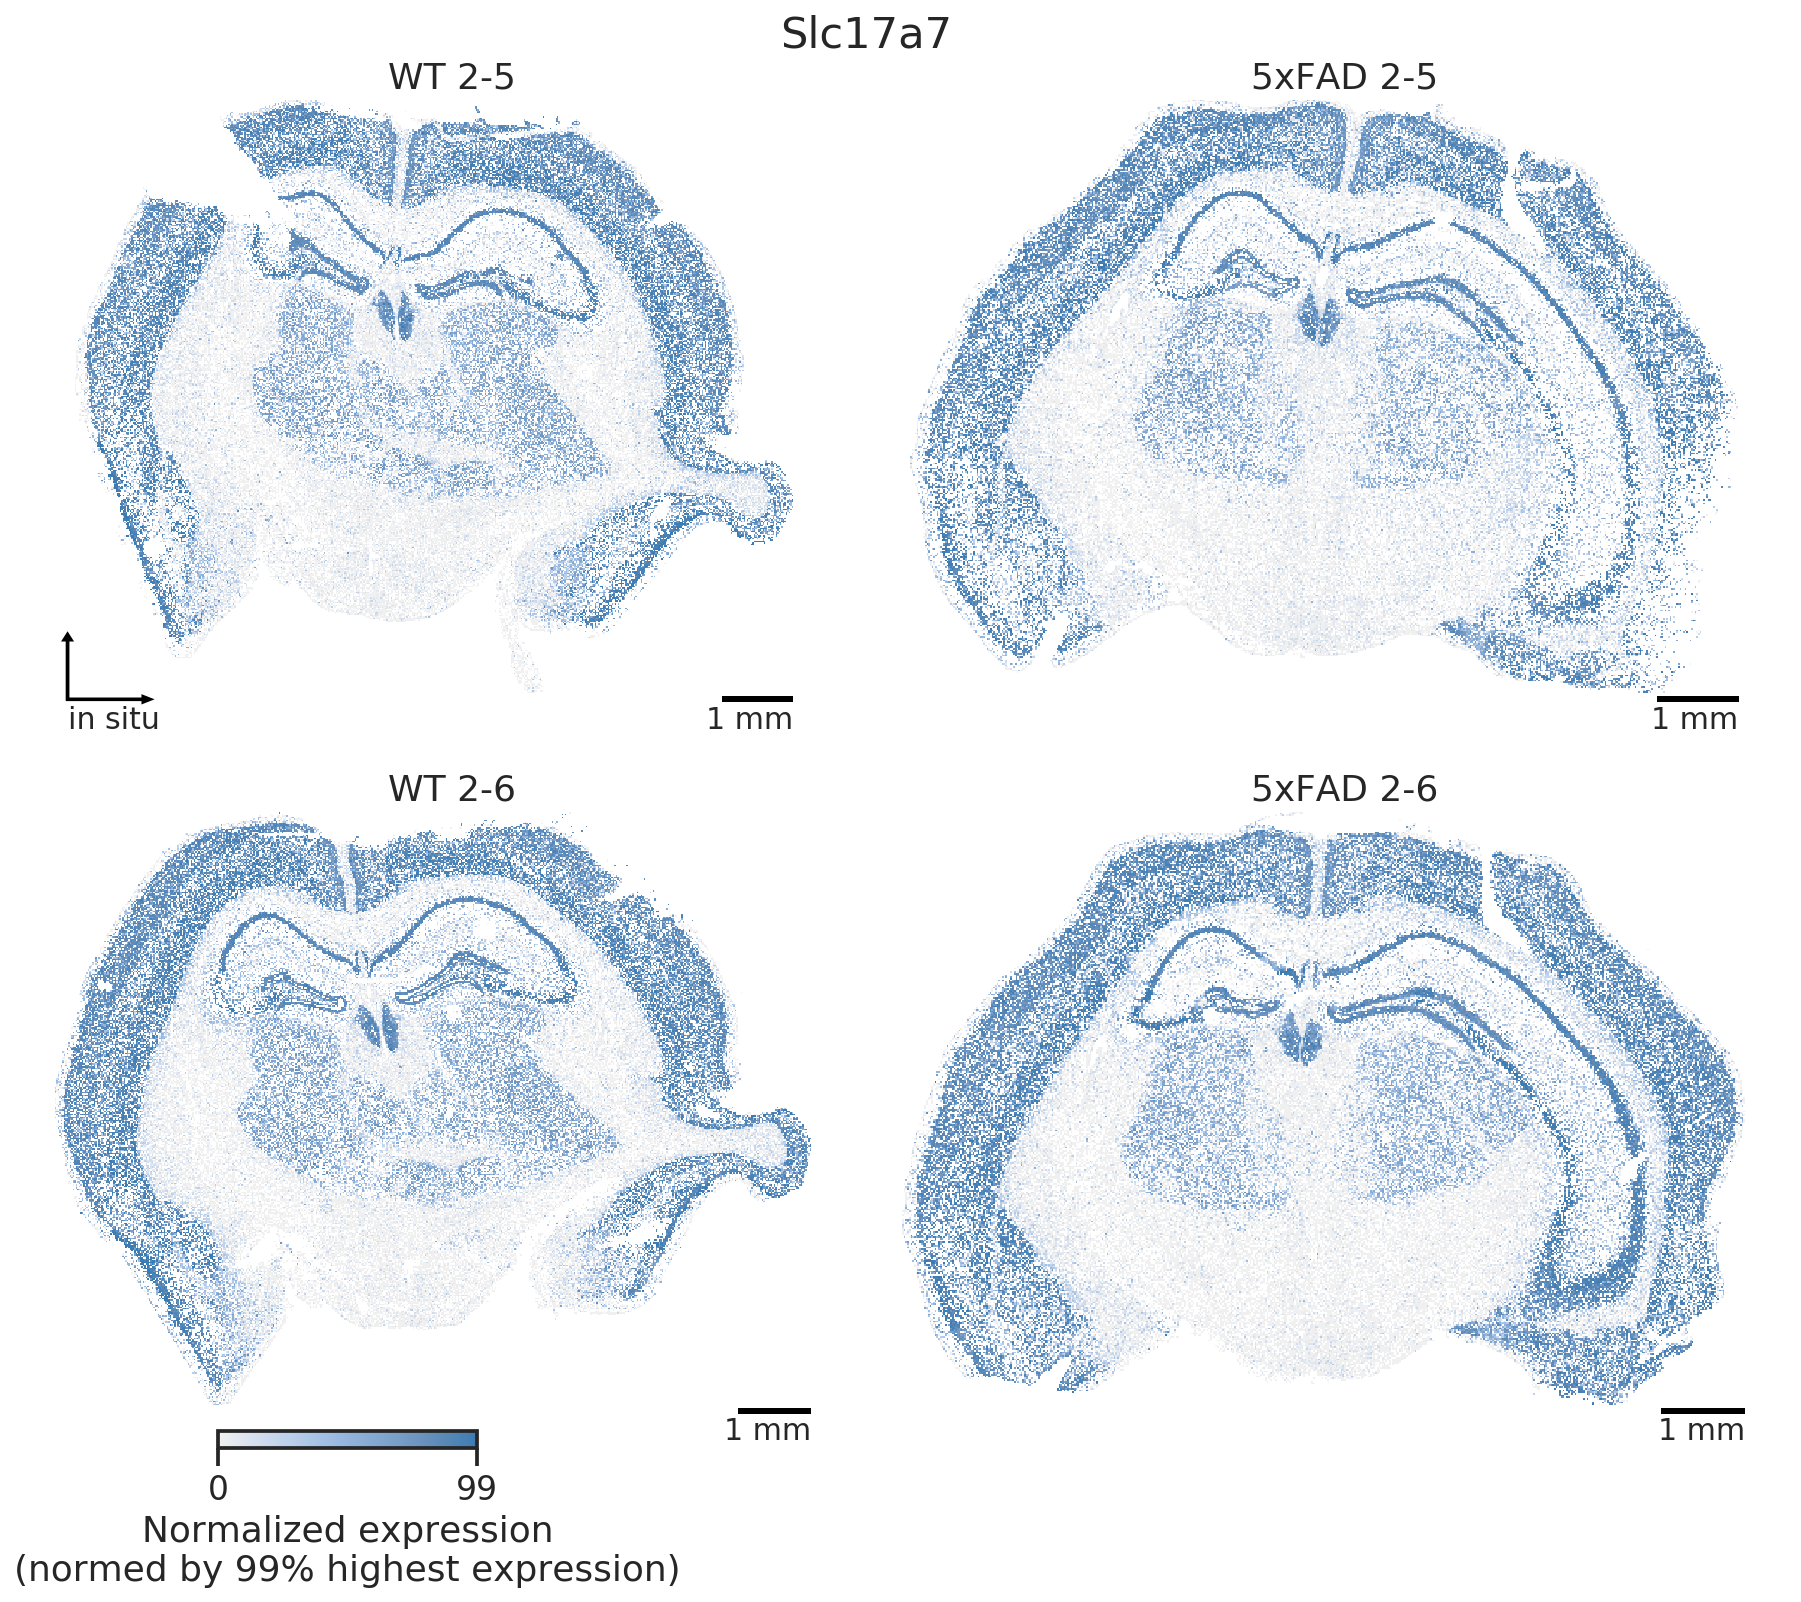

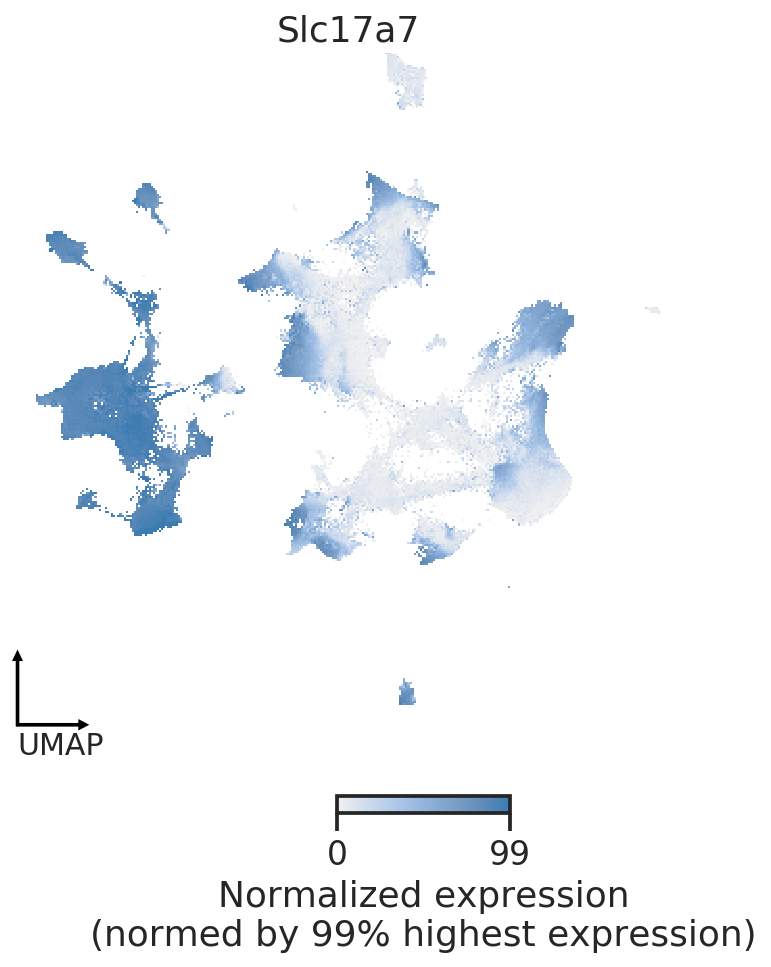

  0%|          | 0/1 [00:05<?, ?it/s]

../figures/2021-07-23_AD_mouse_umap_Slc17a7.pdf


In [9]:
# run genes view
selected_genes = ['Slc17a7']
for gene in tqdm.tqdm(selected_genes):
    # insitu 
    x, y, hue = 'x', 'y', gene
    output = figures.format("insitu_"+gene+".pdf")
    
    fig_plot_gene_insitu_routine(
        thedatagmat, samples, x, y, hue, 
        samples_annot=samples_annot,
        nx=2, ny=2, figsize=(9*2,6*2),
#         close=True,
#         output='', 
        output=output, 
        close=False,
        )
    print(output)
    
    # umap
    x, y, hue = 'umap_1', 'umap_2', gene
    output = figures.format("umap_"+gene+".pdf")
    
    fig_plot_gene_umap_routine(
        thedatagmat, x, y, hue, 
        output=output,
        close=False,
#         close=True,
        )
    print(output)
    break

### Run cluster viz (combined)

In [10]:
clusters = np.sort(thedata['cluster_cat'].cat.categories.values)
clstcolors_obj = powerplot.CategoricalColors(clusters)
palette_clst = clstcolors_obj.to_dict(to_hex=True, output='../data/summary_tables_admouse/palette_clustering_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.json')

palette_clst

saved to file: ../data/summary_tables_admouse/palette_clustering_Xu2_5_R0_Xu2_5_R1_Xu2_6_R0_Xu2_6_R1_2021-07-02.json


{'C1': '#0035f9',
 'C10': '#004bdf',
 'C11': '#005cc4',
 'C12': '#006da8',
 'C13': '#0e7891',
 'C14': '#2f8379',
 'C15': '#3b8c63',
 'C16': '#3f9648',
 'C17': '#3fa02b',
 'C18': '#4da910',
 'C19': '#65ae0e',
 'C2': '#7eb412',
 'C20': '#94b915',
 'C21': '#aabf19',
 'C22': '#bec31c',
 'C23': '#d3c820',
 'C24': '#e7cc23',
 'C25': '#f8cc24',
 'C26': '#fdc120',
 'C27': '#ffb41a',
 'C28': '#ffa714',
 'C3': '#ff990d',
 'C4': '#ff8b07',
 'C5': '#ff7b01',
 'C6': '#ff6c00',
 'C7': '#ff5900',
 'C8': '#ff4500',
 'C9': '#ff2a00'}

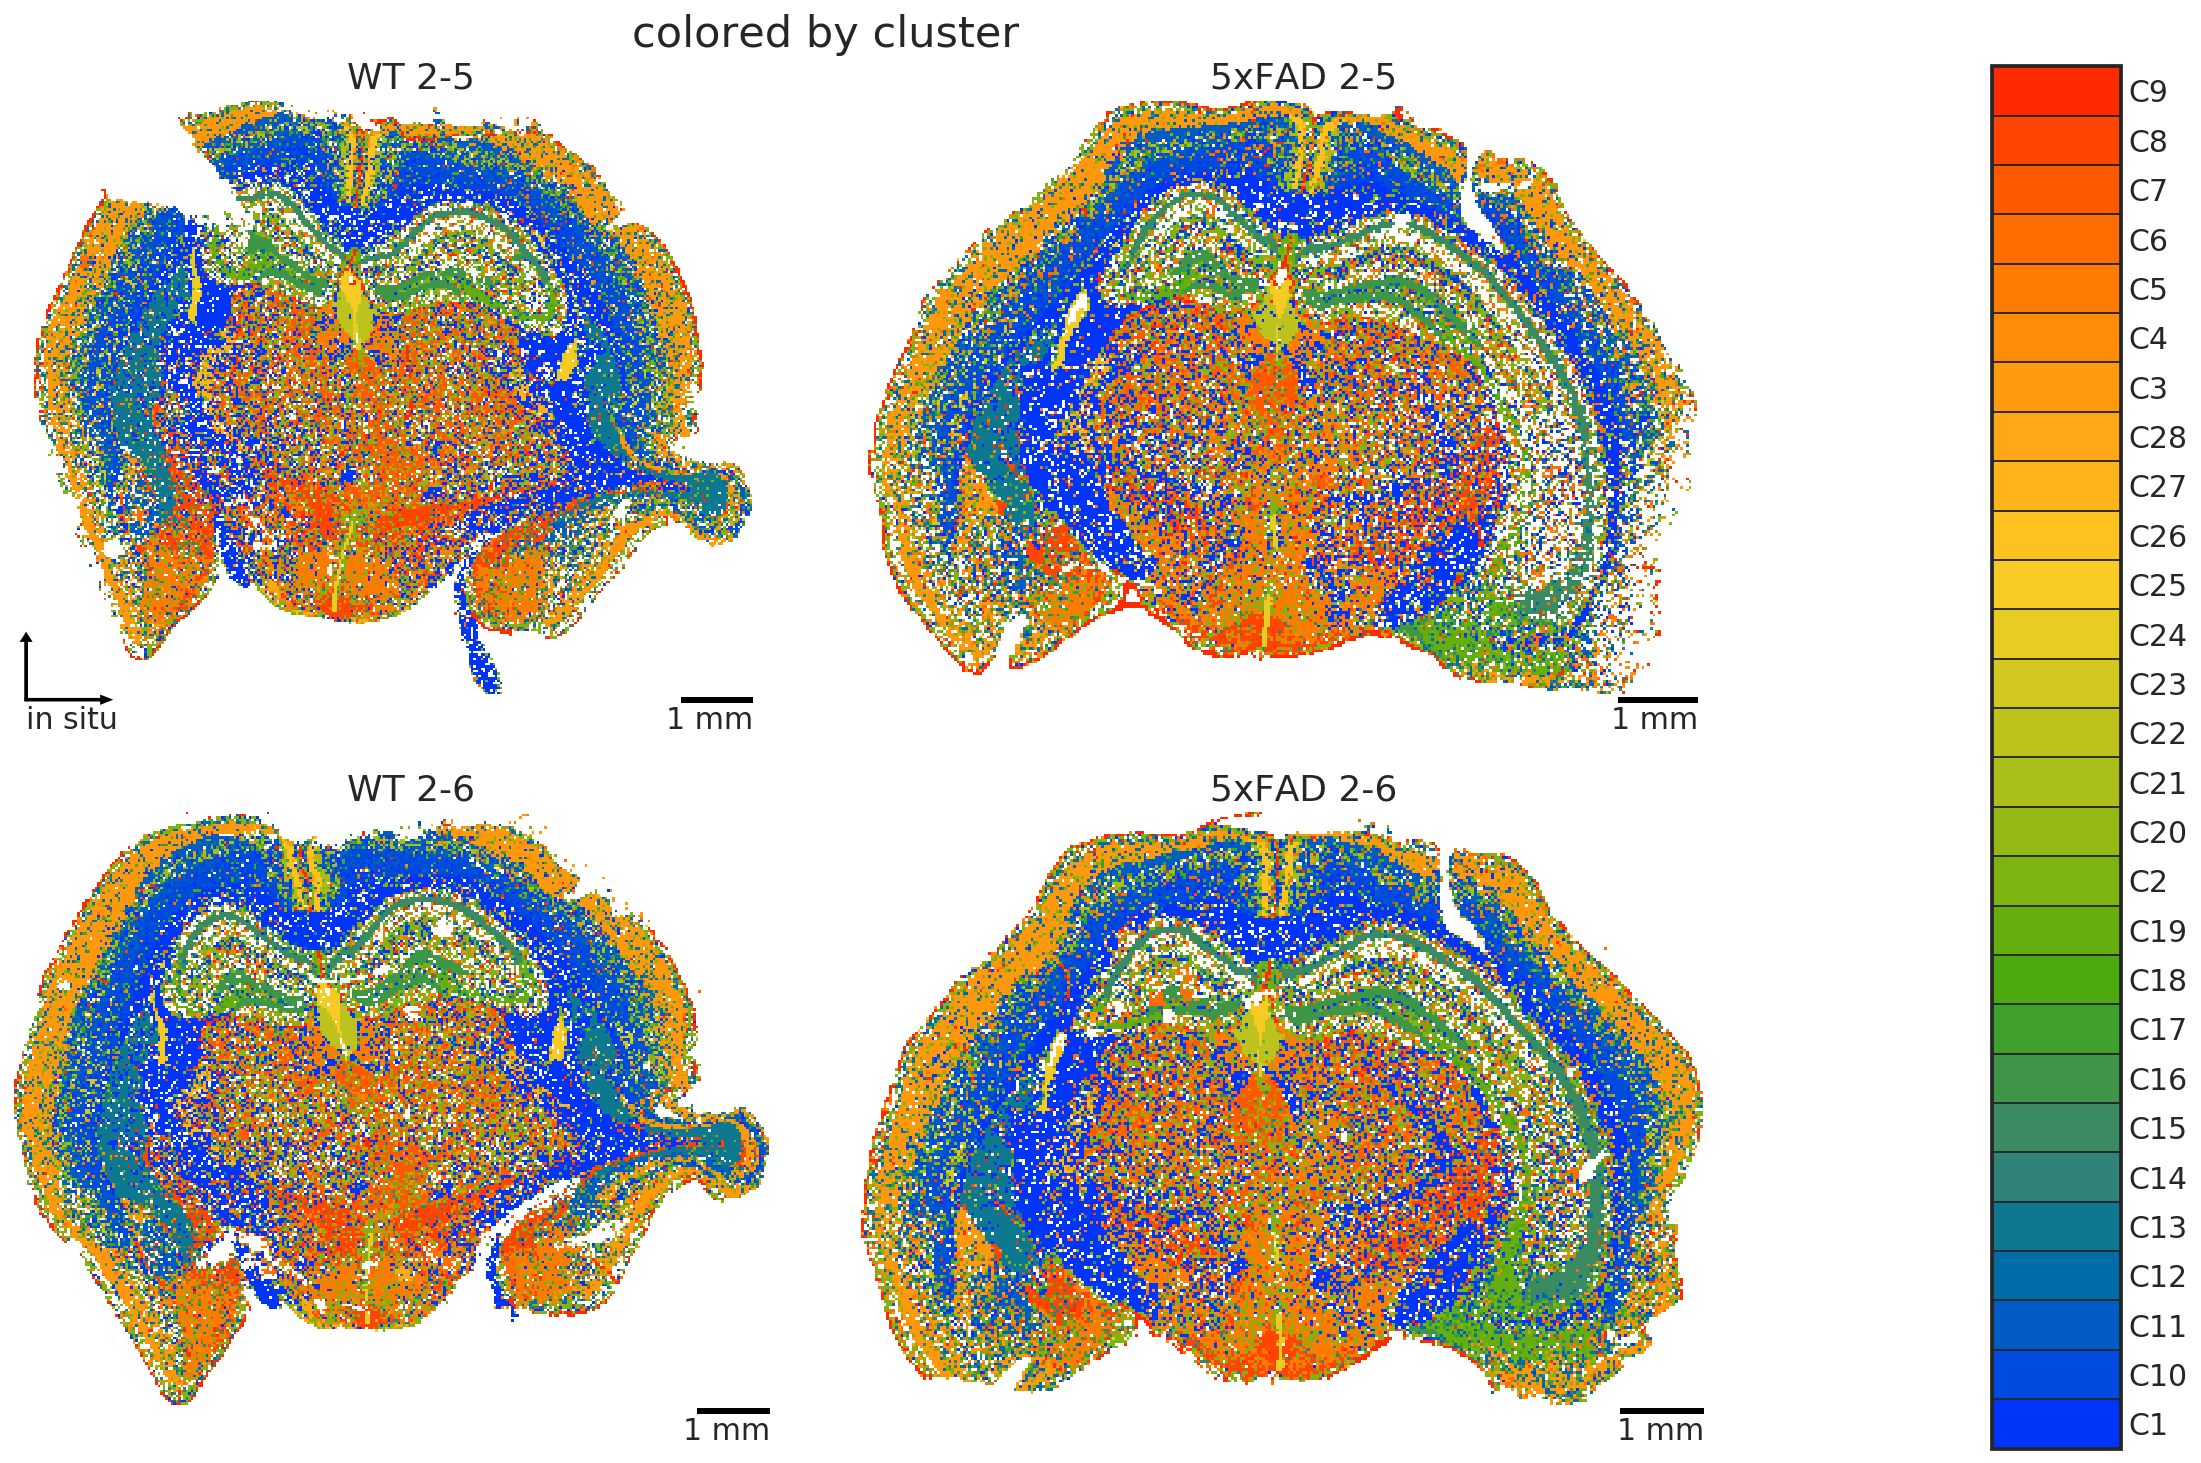

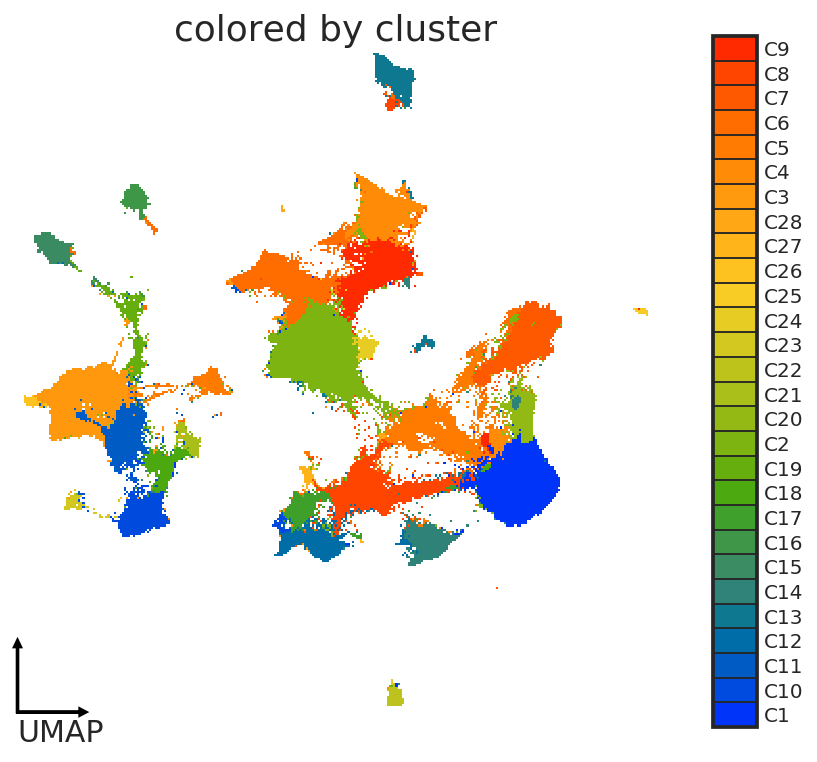

In [11]:
# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("insitu_allclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(9*2,6*2),
    close=close,
    output=output, 
    ) 

# plot all clusters UMAP
x, y, hue = 'umap_1', 'umap_2', 'cluster_cat'
title = 'colored by cluster' 
output = figures.format("umap_allclsts"+".pdf")
close = False
fig_plot_cluster_umap_routine(
    thedata, x, y, hue,
    clstcolors_obj,
    title=title,
    close=close,
    output=output,
    )

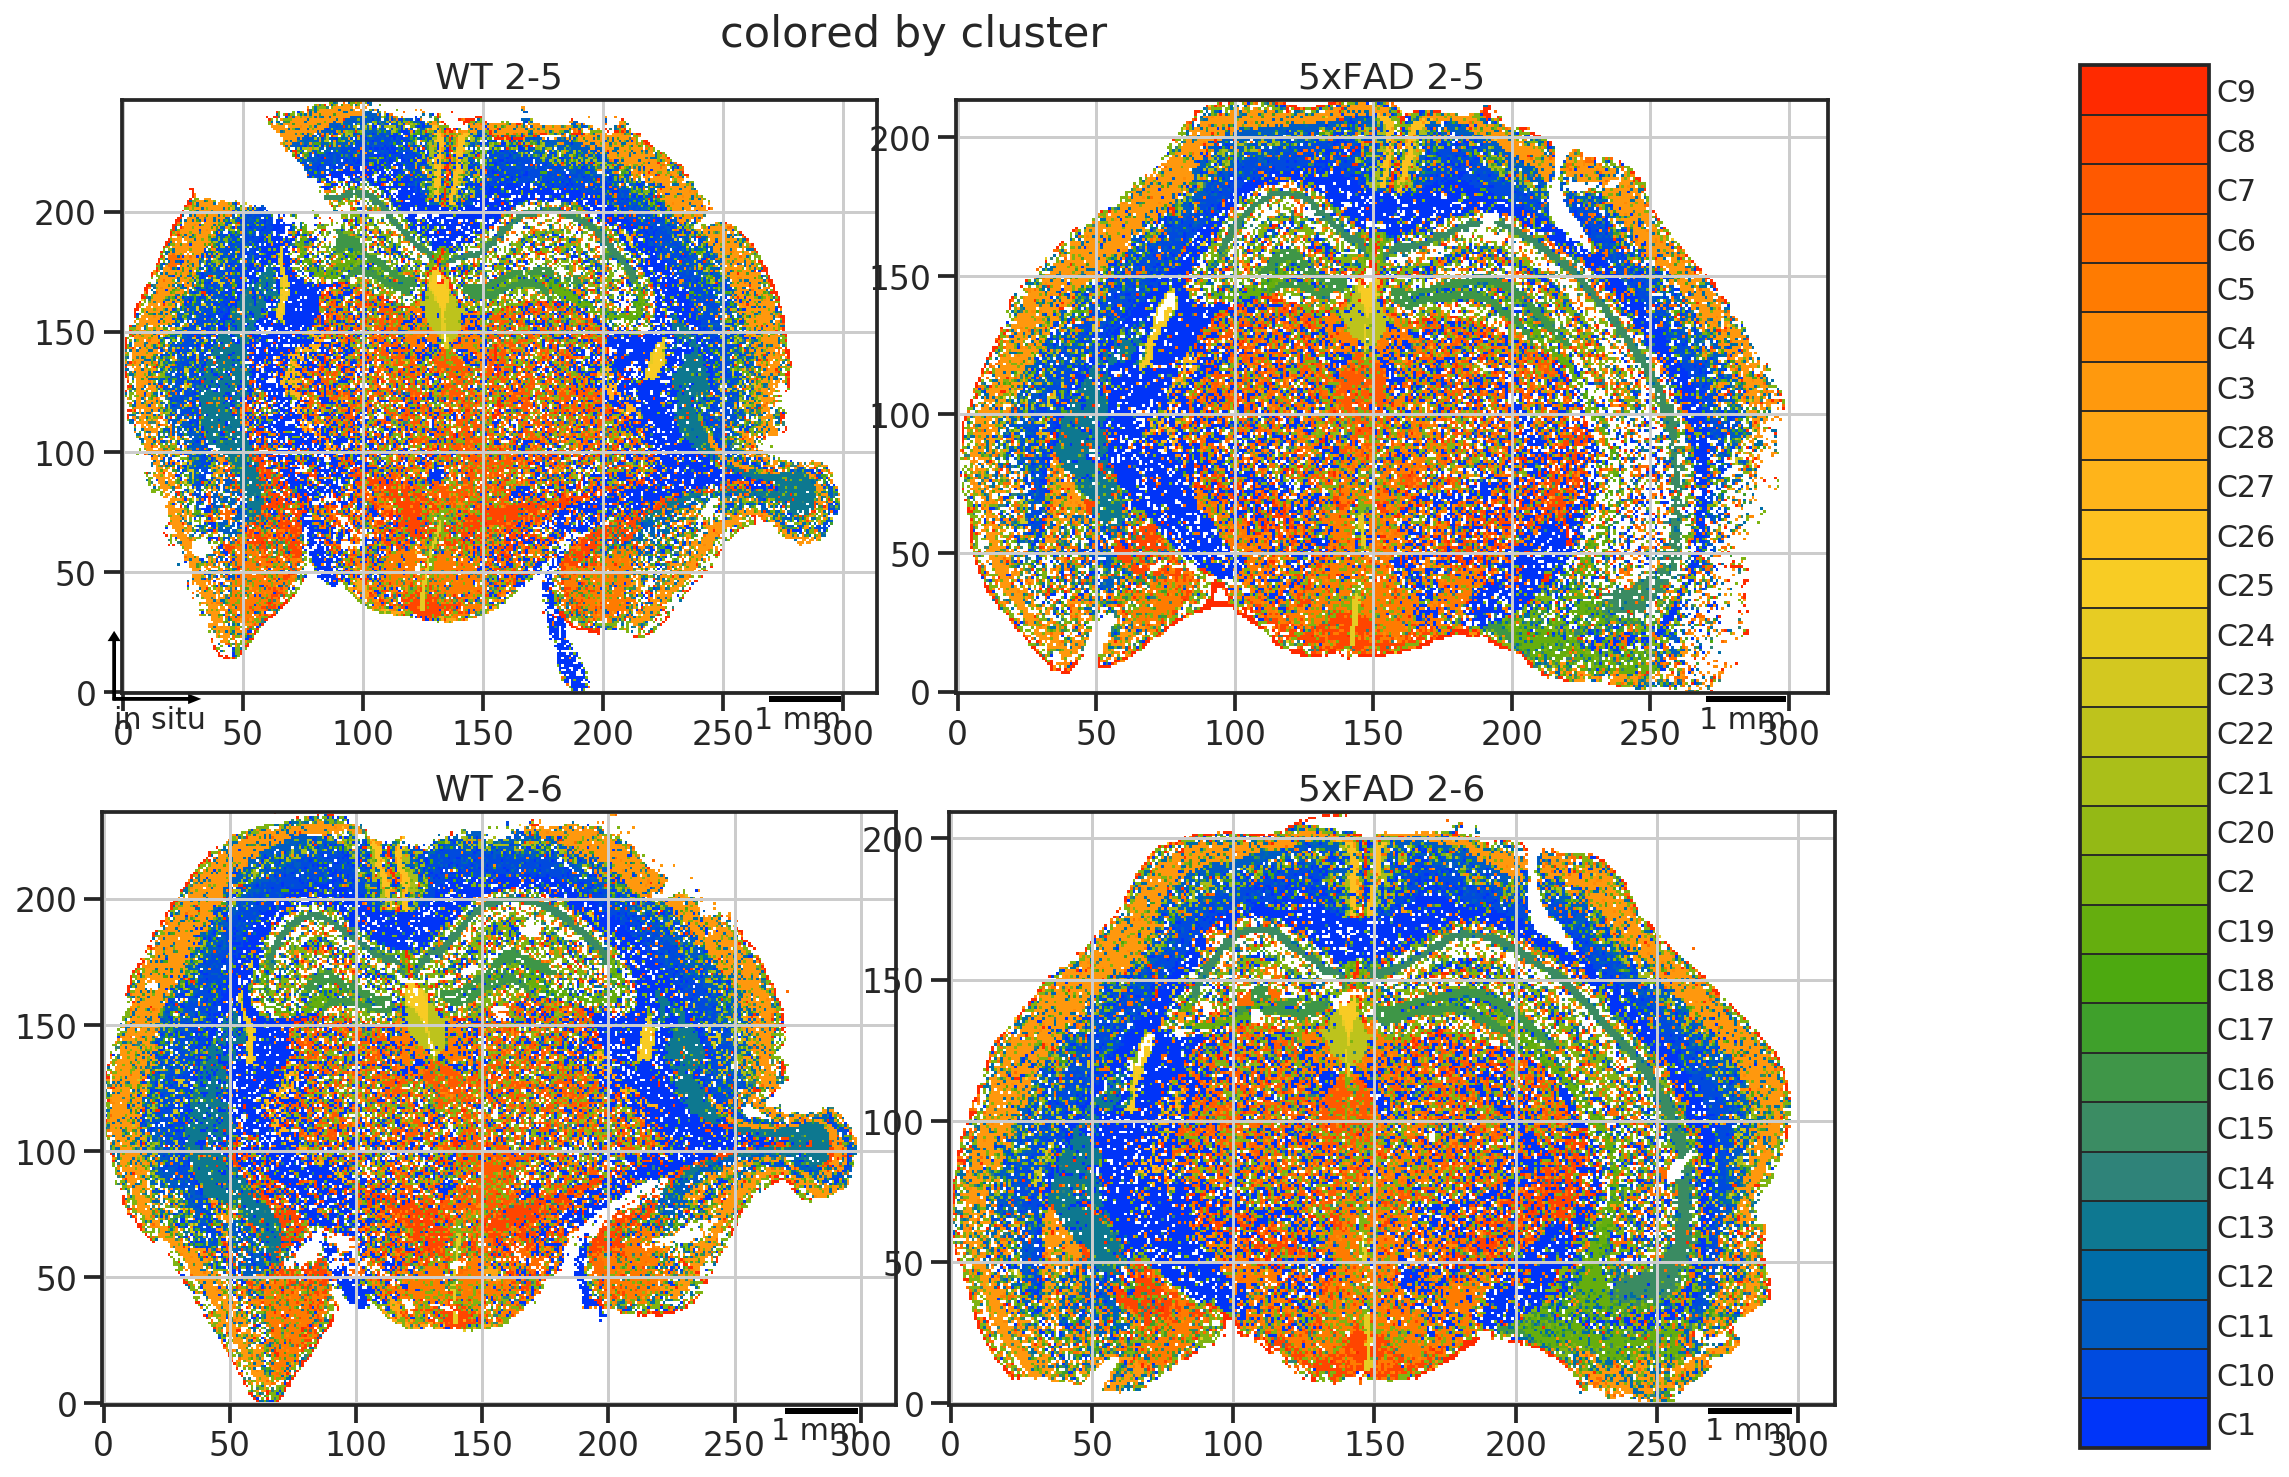

In [12]:
# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("insitu_allclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, samples, x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    suptitle=suptitle,
    nx=2, ny=2, figsize=(9*2,6*2),
    close=close,
    showticks=True,
    roi
    output=output, 
    ) 

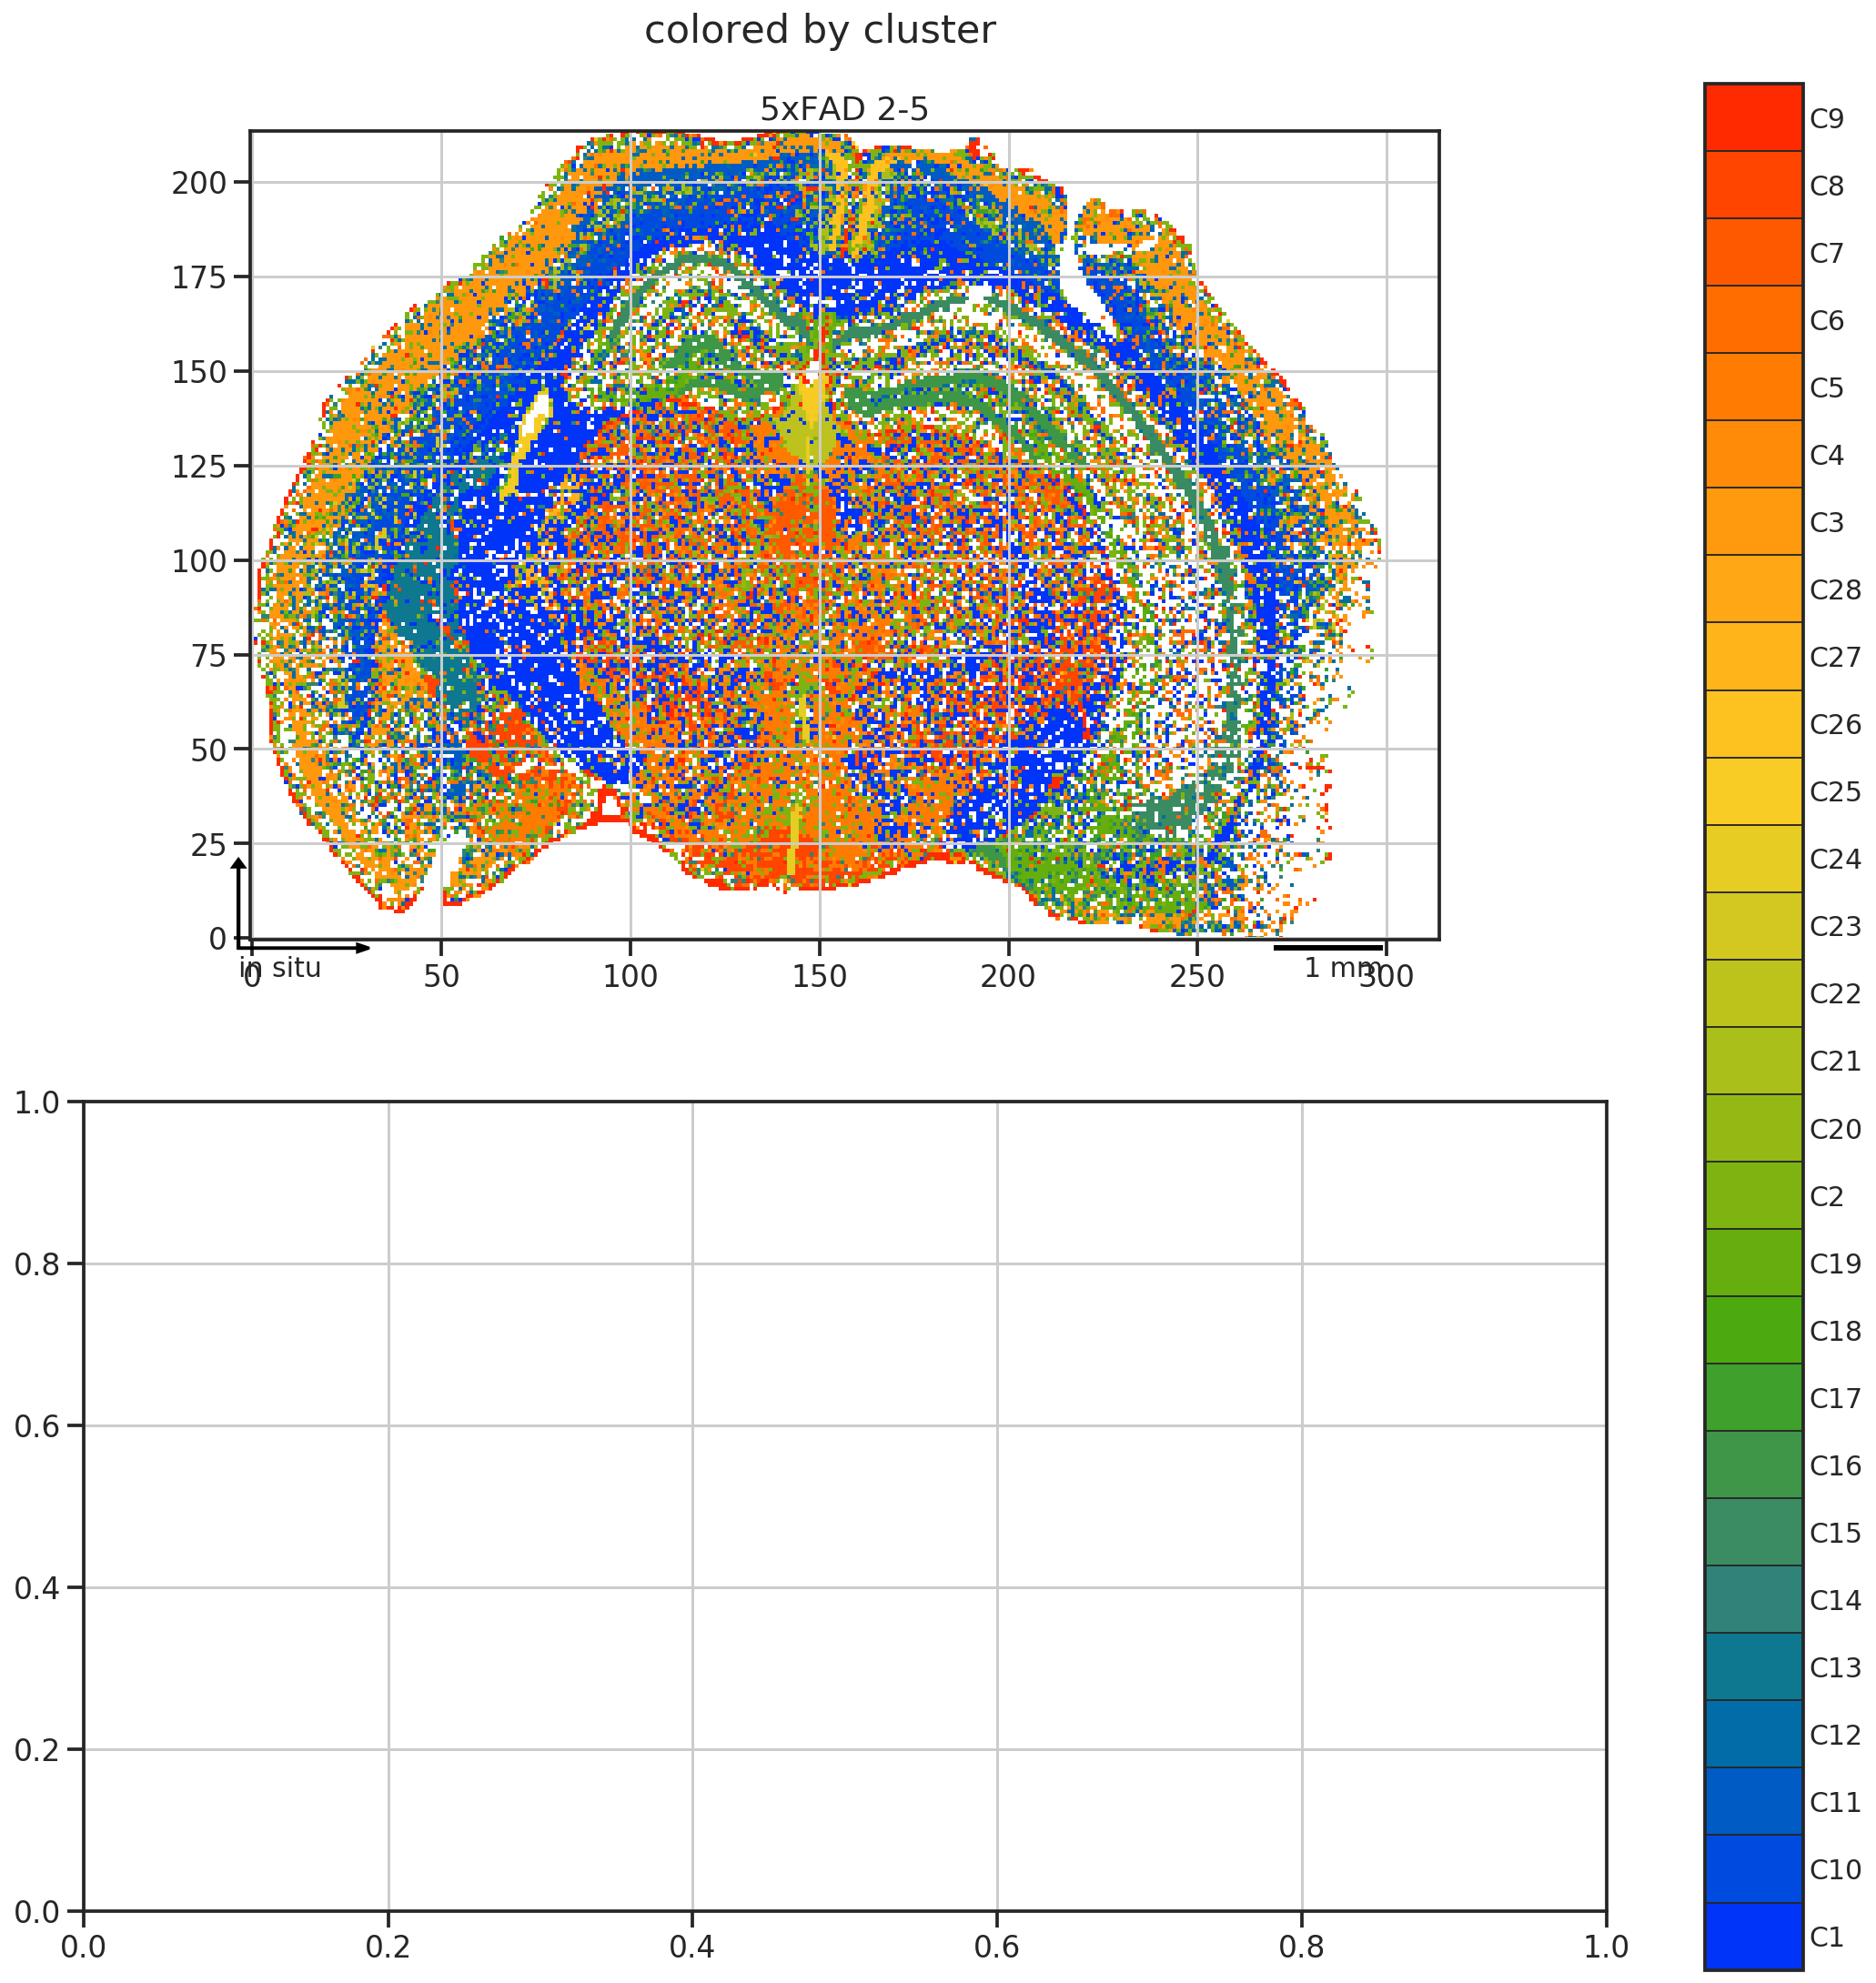

In [22]:
# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("insitu_allclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, [samples[1]], x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    suptitle=suptitle,
    nx=1, ny=2, figsize=(15*1,9*2),
    close=close,
    showticks=True,
    output=output, 
    ) 

In [26]:
thedata[['center_x', 'center_y']]

center_x      center_y
cell                                                               
1180572846630481441529138875642910508     1666.682977  11909.208550
123728997372594040247704579971571050130   1702.052978  11842.626548
141838298513381706222849139789989533595   1724.678979  11874.702549
159299836930912089601219931918867429346   1746.872979  11900.730549
178901354552570069198396499727421283408   1700.432978  11850.888548
...                                               ...           ...
288731779555363425132214621998980143933  10031.446055   3513.729180
297755935958822965475387163406481528974  10035.334056   3418.797178
302821995679673084507195662219260282159  10026.208055   3541.755181
337445700498025519529103520731428088069  10054.180056   3399.519177
78663805403525392231511567041239165491   10009.365455   3490.347180

[450001 rows x 2 columns]

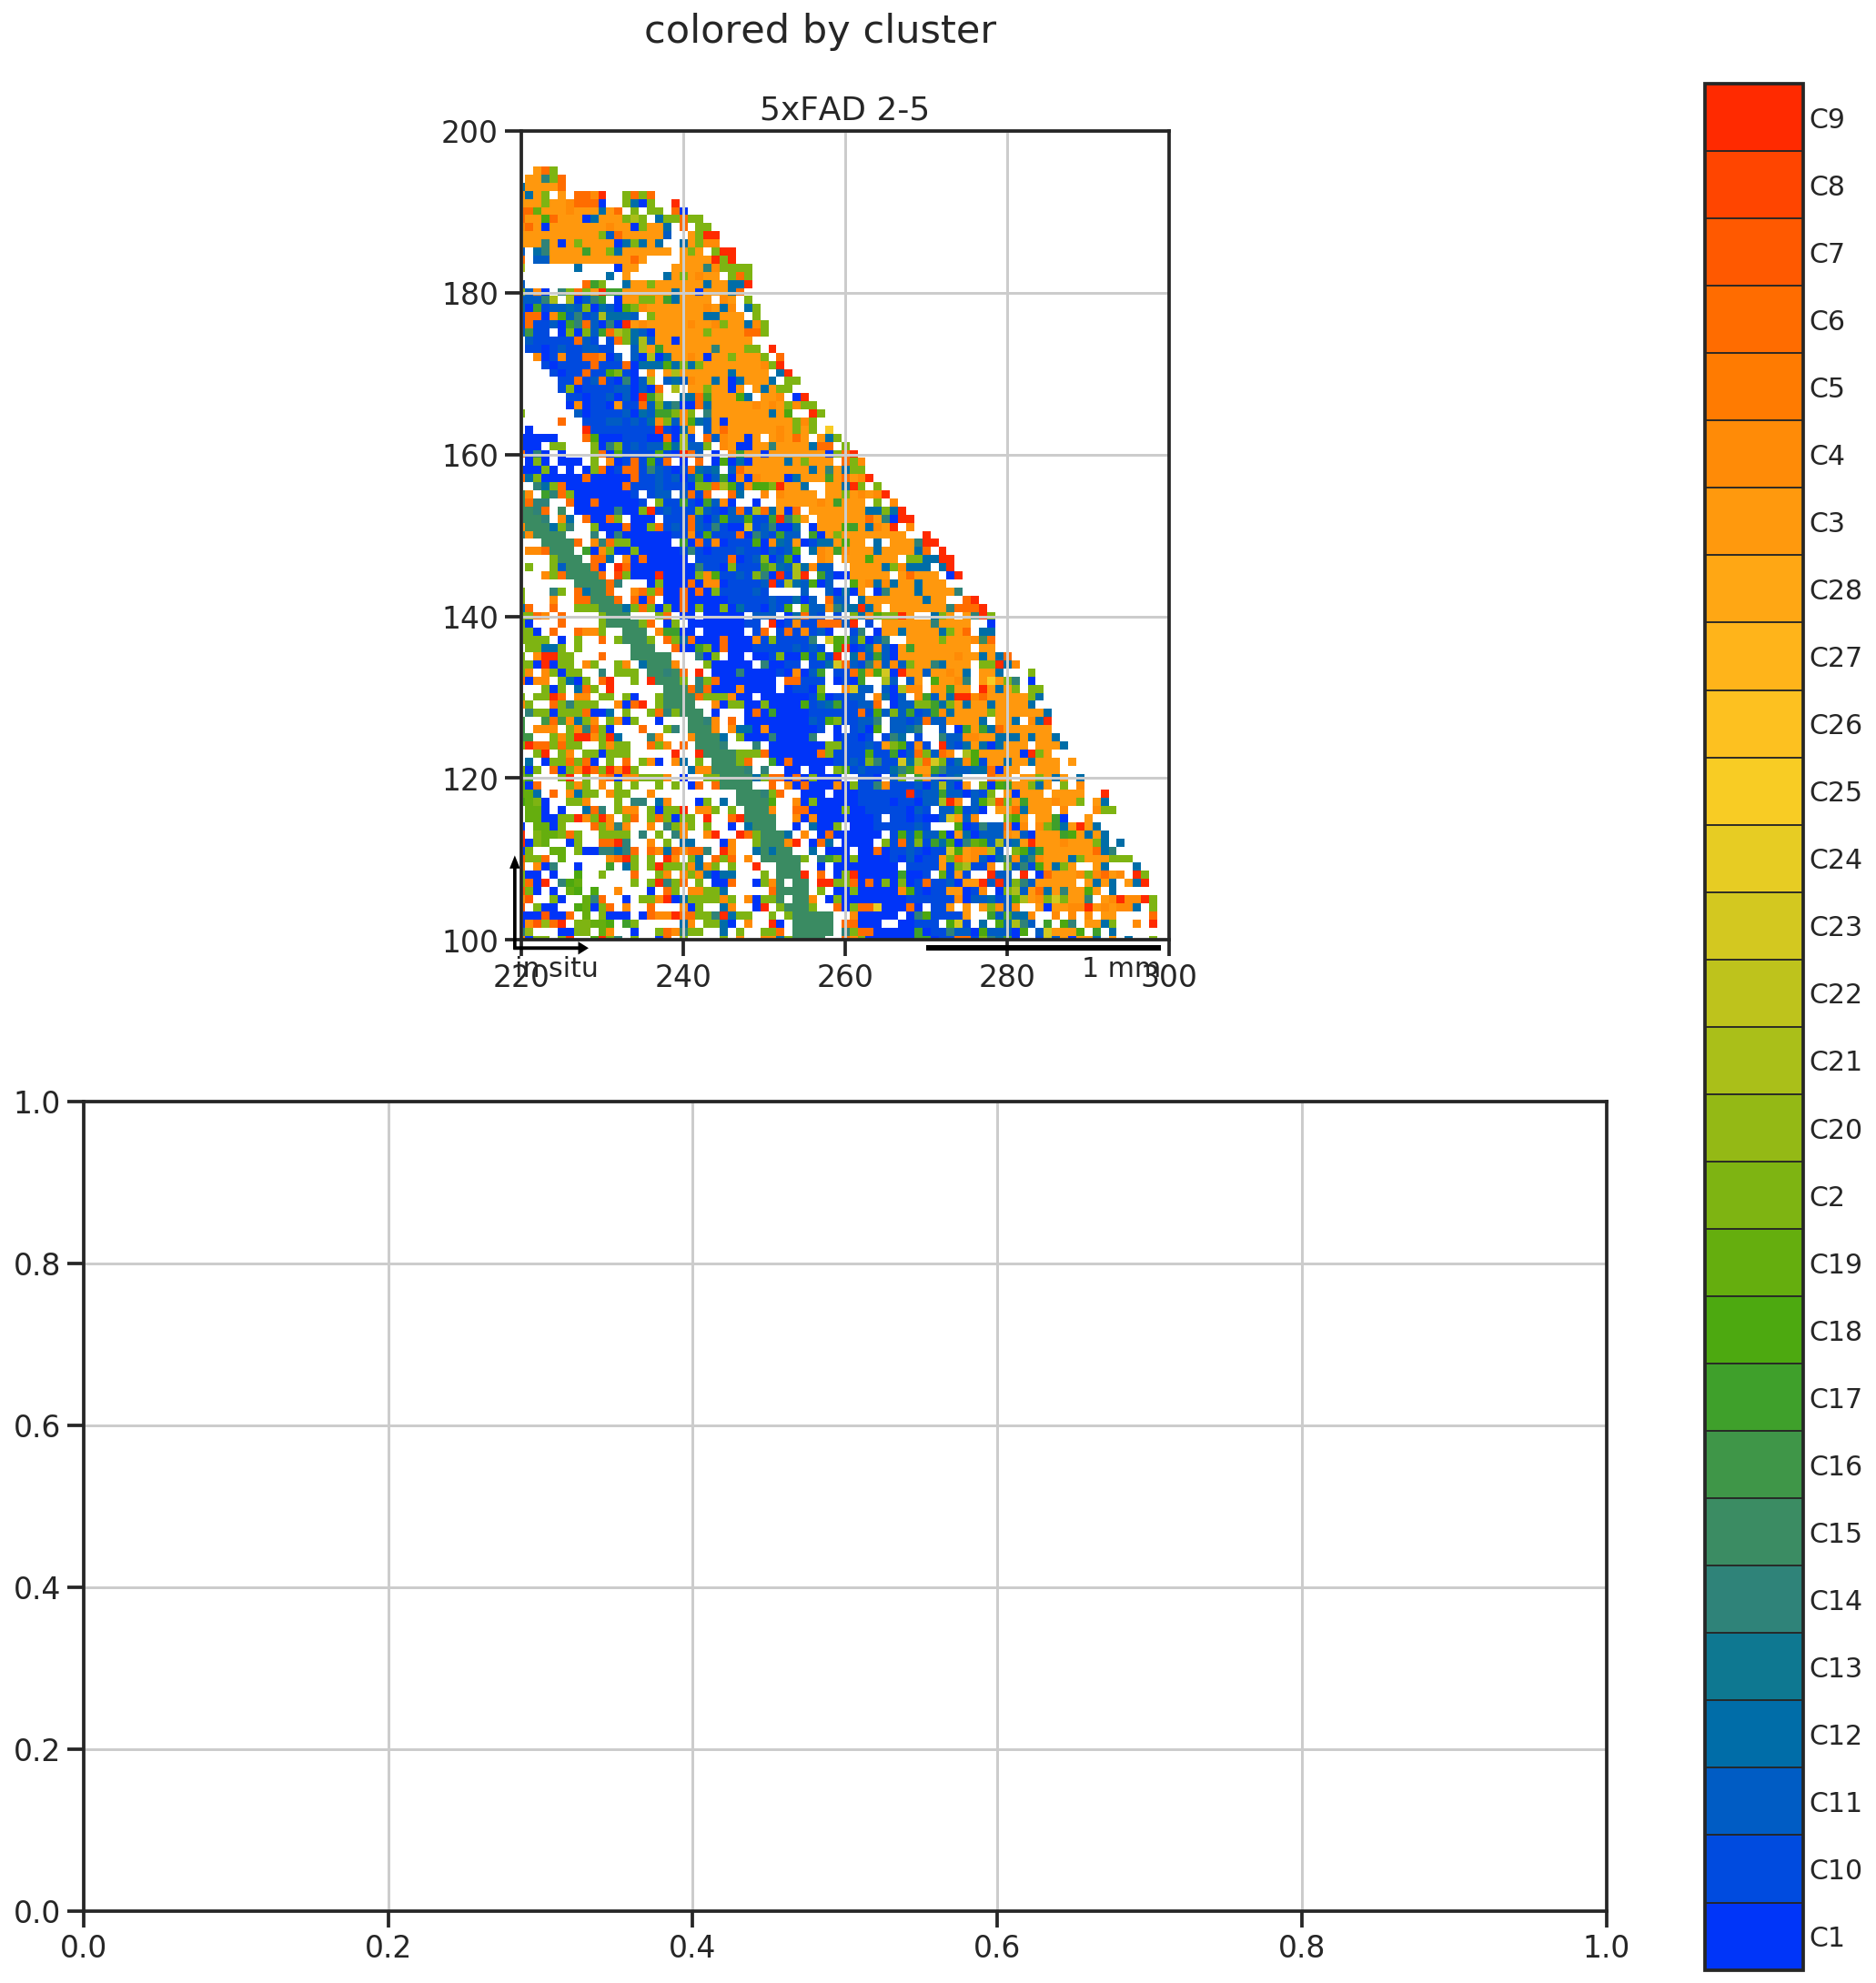

In [23]:
# agg data for each sample
x, y, hue = 'x', 'y', 'cluster_cat'
suptitle = 'colored by cluster' 
output = figures.format("insitu_allclsts"+".pdf")
close = False
    
fig_plot_cluster_insitu_routine(
    thedata, [samples[1]], x, y, hue,
    clstcolors_obj,
    samples_annot=samples_annot,
    suptitle=suptitle,
    nx=1, ny=2, figsize=(15*1,9*2),
    close=close,
    roi=[220,300,100,200],
    showticks=True,
    output=output, 
    ) 

In [45]:
toplot = thedata[thedata['sample']==samples[1]]

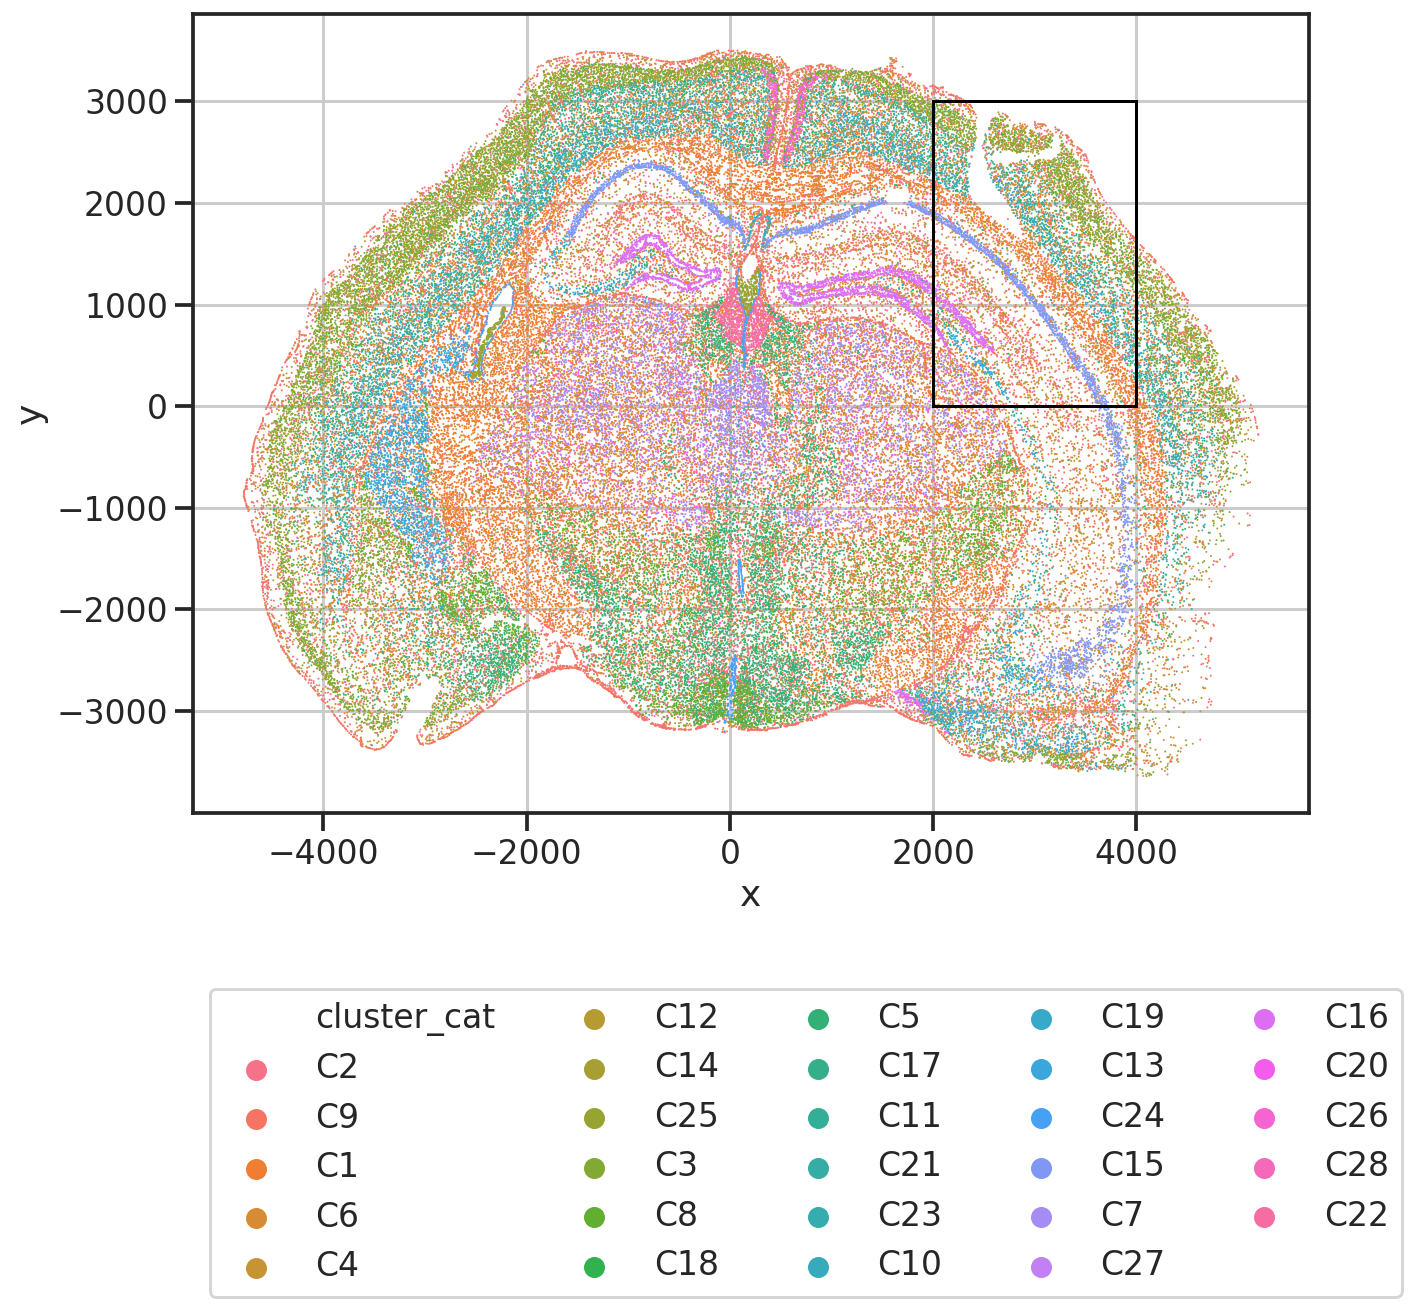

In [65]:
roi = [2000,4000,0,3000]

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='x', y='y', hue='cluster_cat', data=toplot, s=1, ax=ax, edgecolor='none')
ax.legend(ncol=5, bbox_to_anchor=(0, -0.2), loc='upper left')
ax.set_aspect('equal',)
# add a rectangle of ROI right here 
from matplotlib.patches import Rectangle
xmin, xmax, ymin, ymax = roi
ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor='black'))

plt.show()

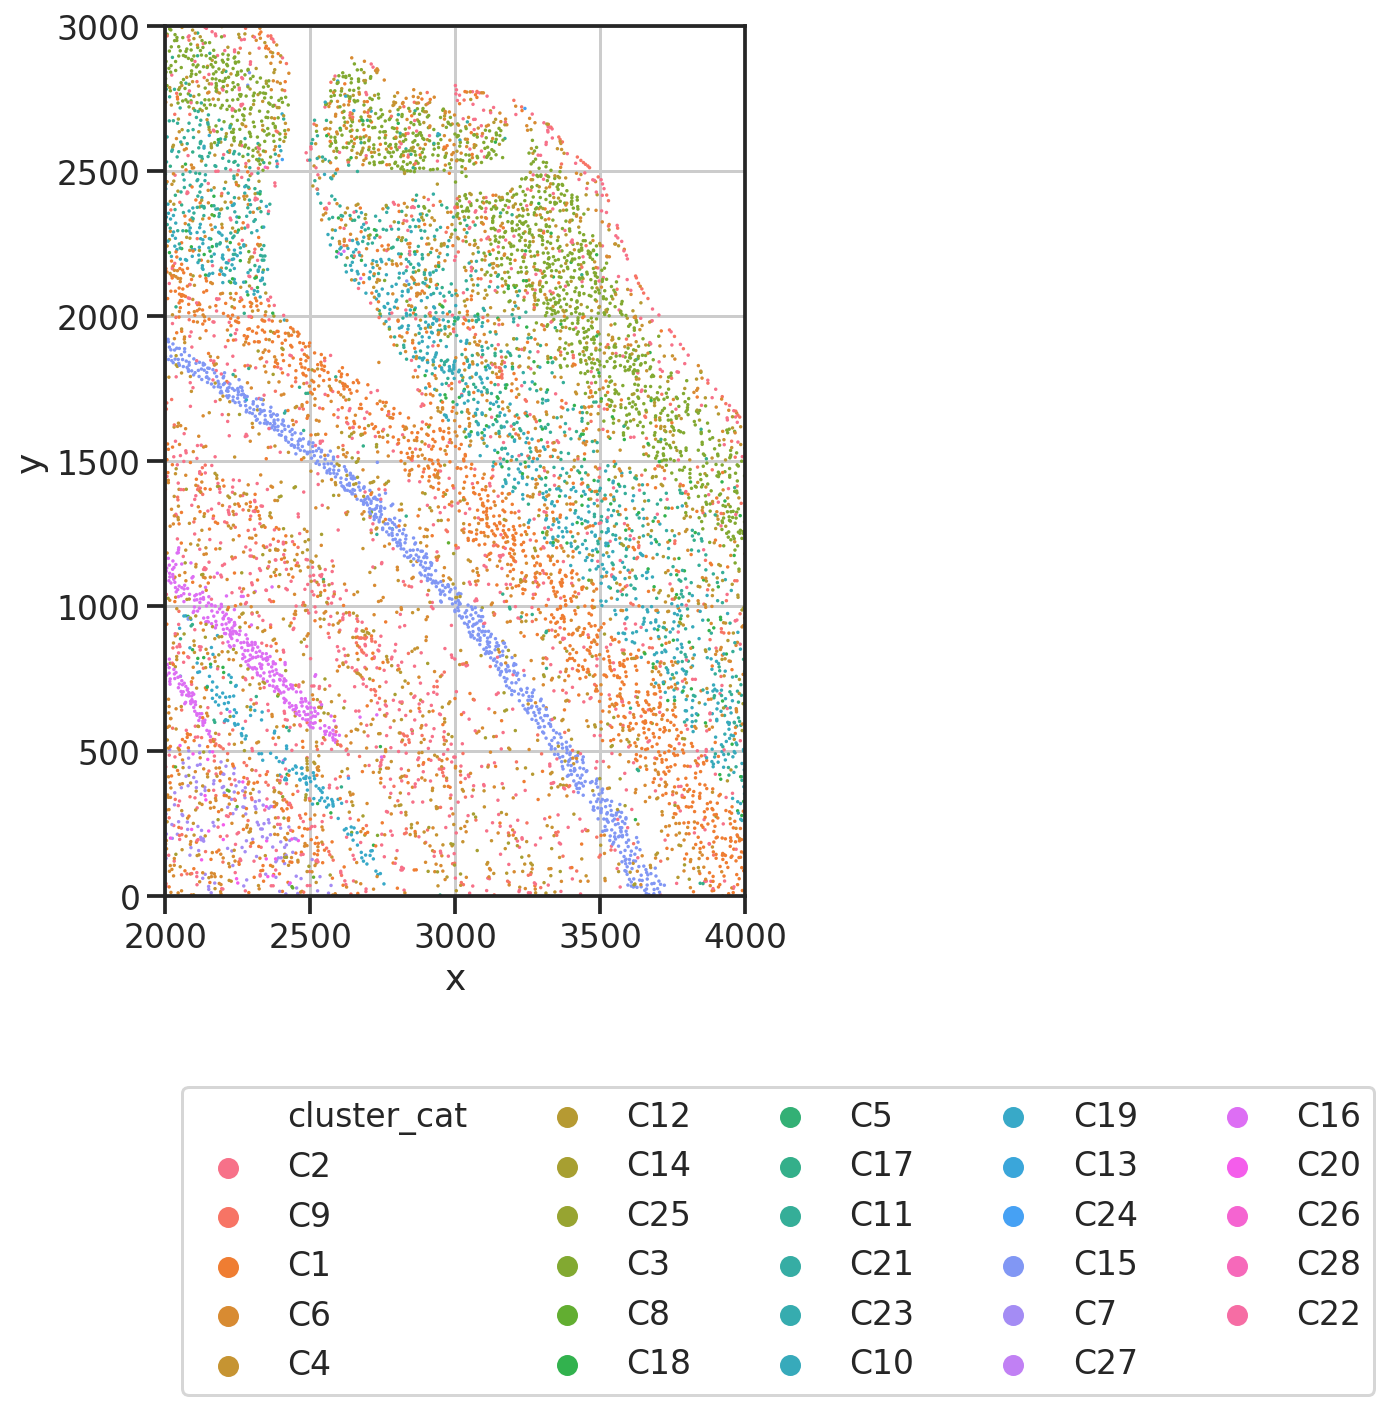

In [60]:
roi = [2000,4000,0,3000]

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='x', y='y', hue='cluster_cat', data=toplot, s=3, ax=ax, edgecolor='none')
ax.legend(ncol=5, bbox_to_anchor=(0, -0.2))
ax.set_aspect('equal')

ax.set_xlim(roi[:2])
ax.set_ylim(roi[2:])

plt.show()